| **Chapter**                   | 2:  Simple compartmental models                       |
| ----------------------------- | ----------------------------------------------------- |
| **Computational Note**        | 2.x: Time and phase                                   |
| **Package prerequisites**     | None                                                  |


# Time and phase

In [38]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import sympy
import matplotlib.patches as patches


COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [39]:
def deriv(t, y, beta, gamma, mu):
    S, I, R = y

    N = S + I + R

    dSdt = mu - beta * S * I - mu * S
    dIdt = beta * S * I - gamma * I - mu * I
    dRdt = gamma * I - mu * R

    return dSdt, dIdt, dRdt

In [40]:
I_0 = 1e-3
S_0 = 1 - I_0
R_0 = 0

y_0 = (S_0, I_0, R_0)

R0 = 3.5
tau = 5
gamma = 1/tau
mu = 0.02
beta = R0 * (gamma + mu)

In [41]:
res = solve_ivp(fun=deriv, t_span = (0, 100), y0=y_0, args=(beta, gamma, mu), method="LSODA")

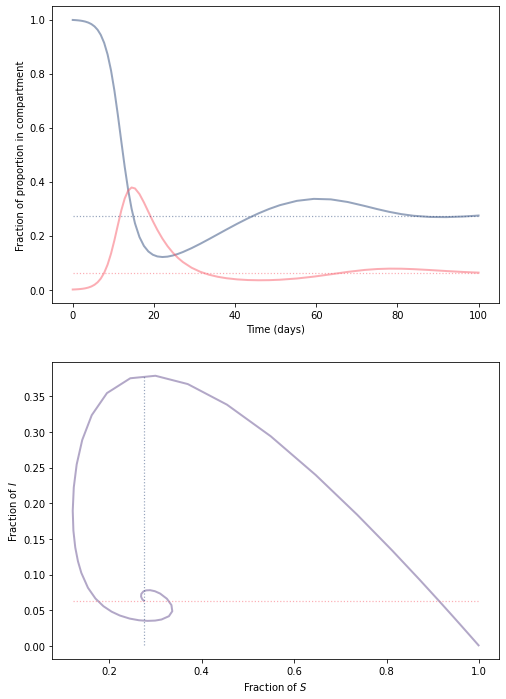

In [42]:
S, I, R = res.y

fig = plt.figure(facecolor="w", figsize=(8, 12))
ax = fig.add_subplot(211, axisbelow=True)

ax.plot(res.t, S, color=COLORS["S"], alpha=0.5, lw=2, label="Susceptible")
ax.plot(res.t, I, color=COLORS["I"], alpha=0.5, lw=2, label="Infectious")
# ax.plot(res.t, R, color=COLORS["R"], alpha=0.5, lw=2, label="Recovered")
ax.hlines(S[-1], xmin=res.t[0], xmax=res.t[-1], color=COLORS["S"], alpha=0.5, lw=1.2, linestyles=":", label="Endemic susceptible equilibrium")
ax.hlines(I[-1], xmin=res.t[0], xmax=res.t[-1], color=COLORS["I"], alpha=0.5, lw=1.2, linestyles=":", label="Endemic infectious equilibrium")
ax.set_xlabel('Time (days)')
ax.set_ylabel("Fraction of proportion in compartment")

ax = fig.add_subplot(212, axisbelow=True)
ax.plot(S, I, color=COLORS["X"], alpha=0.5, lw=2)
ax.hlines(I[-1], xmin=min(S), xmax=max(S), color=COLORS["I"], alpha=0.5, lw=1.2, linestyles=":", label="Endemic infectious equilibrium")
ax.vlines(S[-1], ymin=min(I), ymax=max(I), color=COLORS["S"], alpha=0.5, lw=1.2, linestyles=":", label="Endemic susceptible equilibrium")
ax.set_xlabel("Fraction of $S$")
ax.set_ylabel("Fraction of $I$")

## Identify fixed points symbolically

In [43]:
S, I, R, N, bbeta, ggamma, mmu = sympy.symbols("S, I, R, N, bbeta, ggamma, mmu")

In [44]:
dSdt = mmu - bbeta * S * I - mmu * S
dIdt = bbeta * S * I - ggamma * I - mmu * I

In [45]:
dSzero = sympy.Eq(dSdt, 0)
dIzero = sympy.Eq(dIdt, 0)

In [46]:
equilibria = sympy.solve((dSzero, dIzero), S, I)
print(equilibria)

[(1, 0), (-(-mmu + mmu*(bbeta - ggamma - mmu)/bbeta)/mmu, mmu*(bbeta - ggamma - mmu)/(bbeta*(ggamma + mmu)))]


In [47]:
ee_x = equilibria[1][0].subs([(mmu, mu), (bbeta, beta), (ggamma, gamma)])
ee_y = equilibria[1][1].subs([(mmu, mu), (bbeta, beta), (ggamma, gamma)])

In [48]:
print(f"The endemic equilibrium is at ({ee_x:.3f}, {ee_y:.3f})")

The endemic equilibrium is at (0.286, 0.065)


## Adding a quiver plot

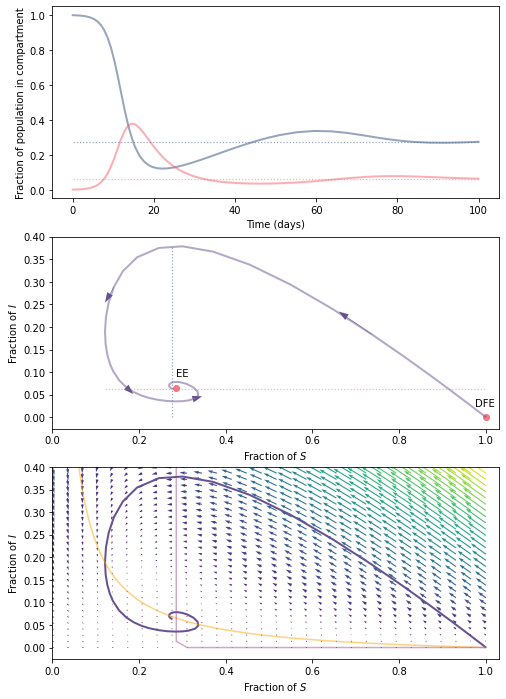

In [49]:
S, I, R = res.y

fig = plt.figure(facecolor="w", figsize=(8, 12))

# PART 1: Time domain plot
ax1 = fig.add_subplot(311, axisbelow=True)

ax1.plot(res.t, S, color=COLORS["S"], alpha=0.5, lw=2, label="Susceptible")
ax1.plot(res.t, I, color=COLORS["I"], alpha=0.5, lw=2, label="Infectious")
ax1.hlines(S[-1], xmin=res.t[0], xmax=res.t[-1], color=COLORS["S"], alpha=0.5, lw=1.2, linestyles=":", label="Endemic susceptible equilibrium")
ax1.hlines(I[-1], xmin=res.t[0], xmax=res.t[-1], color=COLORS["I"], alpha=0.5, lw=1.2, linestyles=":", label="Endemic infectious equilibrium")
ax1.set_xlabel('Time (days)')
ax1.set_ylabel("Fraction of population in compartment")


# PART 2: Phase portrait
ax2 = fig.add_subplot(312, axisbelow=True)
ax2.plot(S, I, color=COLORS["X"], alpha=0.5, lw=2)
ax2.hlines(I[-1], xmin=min(S), xmax=max(S), color=COLORS["I"], alpha=0.5, lw=1.2, linestyles=":", label="Endemic infectious equilibrium")
ax2.vlines(S[-1], ymin=min(I), ymax=max(I), color=COLORS["S"], alpha=0.5, lw=1.2, linestyles=":", label="Endemic susceptible equilibrium")
ax2.set_xlabel("Fraction of $S$")
ax2.set_ylabel("Fraction of $I$")
ax2.set_ylim(-0.025, 0.4)
ax2.set_xlim(0.0, 1.03)

# Add point annotations to DFE and EE
ax2.scatter([1, ee_x], [0, ee_y], color=COLORS["I"], alpha=0.825)
ax2.annotate(xy=[0.975, 0.025], text="DFE")
ax2.annotate(xy=[ee_x, ee_y + 0.025], text="EE")

# Add directional arrows
arrow_density: int = 6

for i in range(1, arrow_density):
    sincrement, iincrement = len(S) // arrow_density, len(I) // arrow_density
    
    if S[i * sincrement] < 0.95:
        ax2.arrow(x=S[i * sincrement], 
                y=I[i * iincrement], 
                dx=S[i * sincrement] - S[i * sincrement - 1], 
                dy=I[i* iincrement] - I[i * iincrement - 1],
                shape="full", 
                lw=0, 
                length_includes_head=True, 
                head_width=.015,
                color=COLORS["X"])


# PART 3: Quiver plot
ax3 = fig.add_subplot(313, axisbelow=True, sharex=ax2, sharey=ax2)

# Set up grid
grid_s, grid_i = np.linspace(0, 1, 30), np.linspace(0, 0.4, 30)
S, I = np.meshgrid(grid_s, grid_i)

# Calculate derivatives
dS = mu - beta * S * I - mu * S
dI = beta * S * I - gamma * I - mu * I

# Calculate the magnitude of the vectors [dS, dI] and scaling it up a little
m = np.hypot(dS, dI)

ax3.quiver(S, I, dS, dI, m)
ax3.plot(res.y[0], res.y[1], color=COLORS["X"], alpha=1.0, lw=2)

# Draw the X isocline
ax3.contour(S, I, dS, levels=[0], linewidths=1.5, alpha=0.5, colors=COLORS["E"])
# Draw the Y isocline
ax3.contour(S, I, dI, levels=[0], linewidths=1.5, alpha=0.5, colors=COLORS["R"])

ax3.set_xlabel("Fraction of $S$")
ax3.set_ylabel("Fraction of $I$")

plt.savefig("phase_space_with_quiver_plot.pdf")